<a href="https://colab.research.google.com/github/Martin2-kioko/mymodel/blob/main/LSTM_MODEL_1_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**importing the required libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import os

In [2]:

# Load dataset
data = pd.read_csv('MVS.csv')
print(data.head)

<bound method NDFrame.head of            Date      Open_M      High_M       Low_M     Close_M  Adj Close_M  \
0      6/2/2008   30.926001   32.000000   30.257000   32.000000    29.529486   
1      6/3/2008   31.386999   31.399000   30.235001   30.740000    28.366755   
2      6/4/2008   30.745001   30.959999   29.454000   29.740000    27.443956   
3      6/5/2008   29.951000   30.615999   29.544001   30.615999    28.252338   
4      6/6/2008   30.228001   30.242001   29.481001   29.573000    27.289856   
...         ...         ...         ...         ...         ...          ...   
4042  6/24/2024  454.929993  463.070007  454.929993  456.959991   456.959991   
4043  6/25/2024  458.480011  460.309998  453.799988  455.649994   455.649994   
4044  6/26/2024  452.750000  454.679993  451.390015  452.380005   452.380005   
4045  6/27/2024  448.570007  448.700012  442.000000  442.750000   442.750000   
4046  6/28/2024  444.640015  448.299988  438.720001  441.160004   441.160004   

      Vol

In [3]:
# Check for missing values
print(data.isnull().sum())

Date           0
Open_M         0
High_M         0
Low_M          0
Close_M        0
Adj Close_M    0
Volume_M       0
Open_V         0
High_V         0
Low_V          0
Close_V        0
Adj Close_V    0
Volume_V       0
dtype: int64


In [4]:
# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])
# Set 'Date' as the index
data.set_index('Date', inplace=True)


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4047 entries, 2008-06-02 to 2024-06-28
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open_M       4047 non-null   float64
 1   High_M       4047 non-null   float64
 2   Low_M        4047 non-null   float64
 3   Close_M      4047 non-null   float64
 4   Adj Close_M  4047 non-null   float64
 5   Volume_M     4047 non-null   int64  
 6   Open_V       4047 non-null   float64
 7   High_V       4047 non-null   float64
 8   Low_V        4047 non-null   float64
 9   Close_V      4047 non-null   float64
 10  Adj Close_V  4047 non-null   float64
 11  Volume_V     4047 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 411.0 KB
None


**Descriptive statistics**

In [6]:
print(data.describe())

            Open_M       High_M        Low_M      Close_M  Adj Close_M  \
count  4047.000000  4047.000000  4047.000000  4047.000000  4047.000000   
mean    164.535600   166.170139   162.857876   164.563858   160.646182   
std     138.620480   139.946015   137.248286   138.635551   138.057771   
min      12.100000    12.736000    11.305000    11.918000    11.024753   
25%      42.459502    42.865499    42.062000    42.452500    39.624086   
50%      97.440002    98.089996    96.699997    97.599998    92.752449   
75%     304.414994   306.979995   300.304993   303.910004   297.765701   
max     488.529999   490.000000   483.640015   488.640015   487.964142   

           Volume_M       Open_V       High_V        Low_V      Close_V  \
count  4.047000e+03  4047.000000  4047.000000  4047.000000  4047.000000   
mean   8.249296e+06   107.988356   108.965956   106.999128   108.003625   
std    1.140882e+07    82.319225    83.020901    81.600647    82.319975   
min    6.411000e+05    10.672500 

**Time Series Visualization**

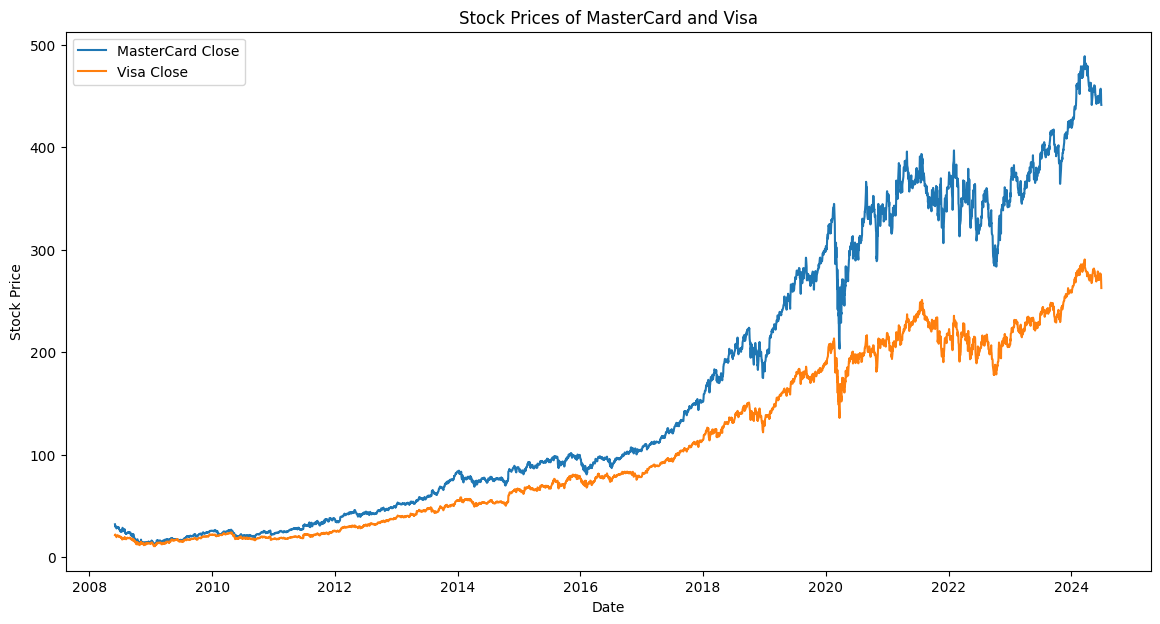

In [7]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close_M'], label='MasterCard Close')
plt.plot(data.index, data['Close_V'], label='Visa Close')
plt.title('Stock Prices of MasterCard and Visa')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**Calculating the year trading volumes**

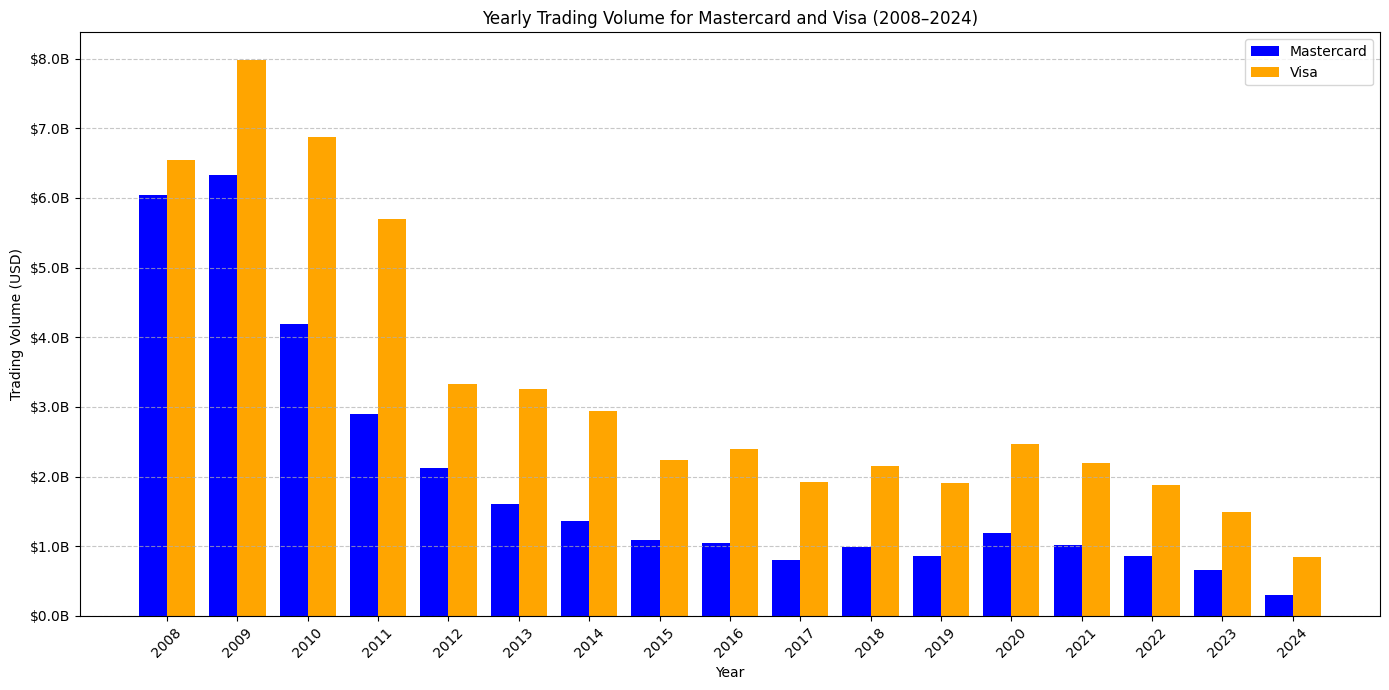

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to format Y-axis labels as USD with billions
def billions(x, pos):
    return f'${x * 1e-9:.1f}B'

# Grouping and plotting
yearly_volume = data.groupby(data.index.year)[['Volume_M', 'Volume_V']].sum()
yearly_volume.index = yearly_volume.index.astype(str)

plt.figure(figsize=(14, 7))
bar_width = 0.4
years = yearly_volume.index
x = range(len(years))

plt.bar([i - bar_width/2 for i in x], yearly_volume['Volume_M'],
        width=bar_width, label='Mastercard', color='blue')
plt.bar([i + bar_width/2 for i in x], yearly_volume['Volume_V'],
        width=bar_width, label='Visa', color='orange')

plt.xlabel('Year')
plt.ylabel('Trading Volume (USD)')
plt.title('Yearly Trading Volume for Mastercard and Visa (2008–2024)')
plt.xticks(ticks=x, labels=years, rotation=45)
plt.legend()

# Format Y-axis as billions of USD
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions))

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


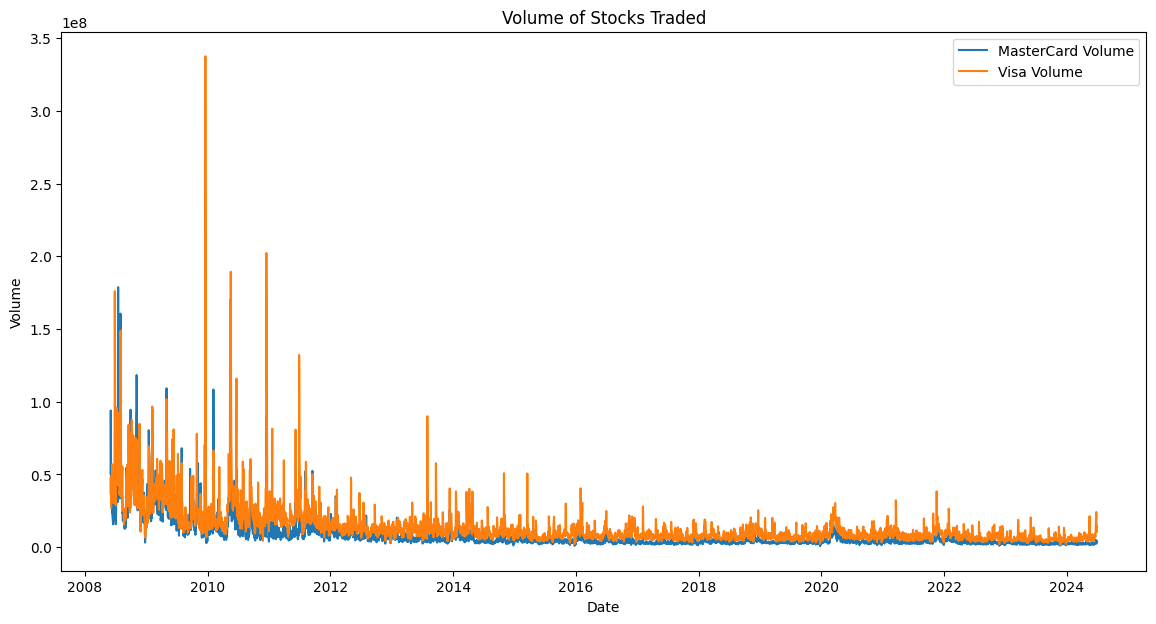

In [ ]:
# Plot the volume of stocks traded
plt.figure(figsize=(14, 7))
plt.plot(data['Volume_M'], label='MasterCard Volume')
plt.plot(data['Volume_V'], label='Visa Volume')
plt.title('Volume of Stocks Traded')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

**Volatility Analysis**

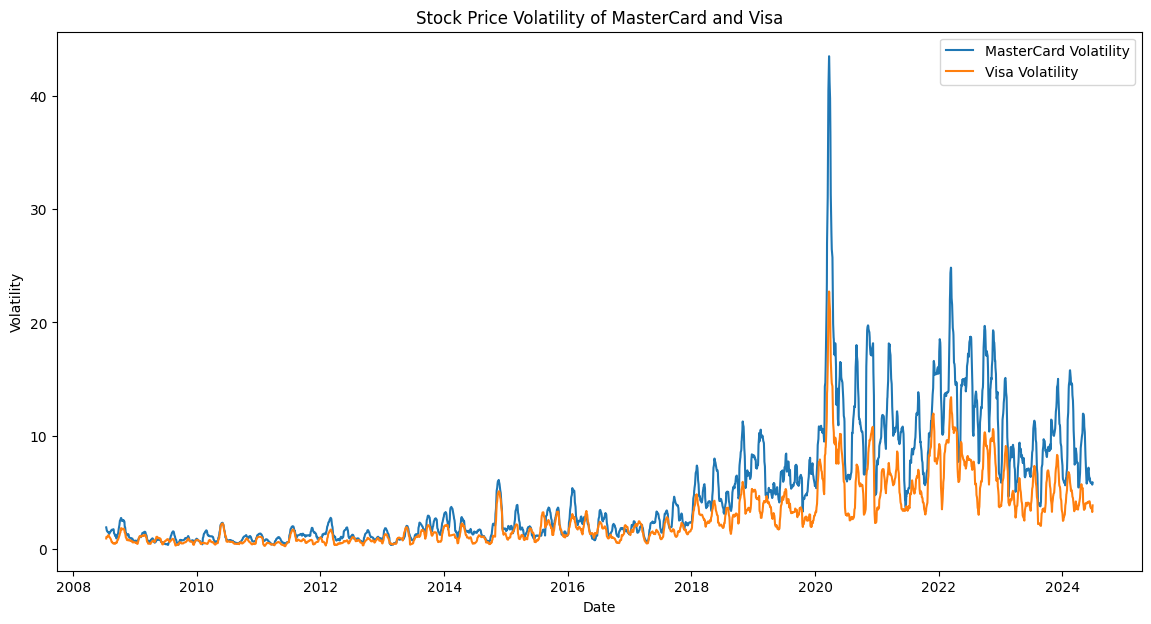

In [ ]:
# Calculate rolling standard deviation (volatility)
data['Volatility_M'] = data['Close_M'].rolling(window=30).std()
data['Volatility_V'] = data['Close_V'].rolling(window=30).std()

# Plot the volatility
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Volatility_M'], label='MasterCard Volatility')
plt.plot(data.index, data['Volatility_V'], label='Visa Volatility')
plt.title('Stock Price Volatility of MasterCard and Visa')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


**Comparative Analysis**

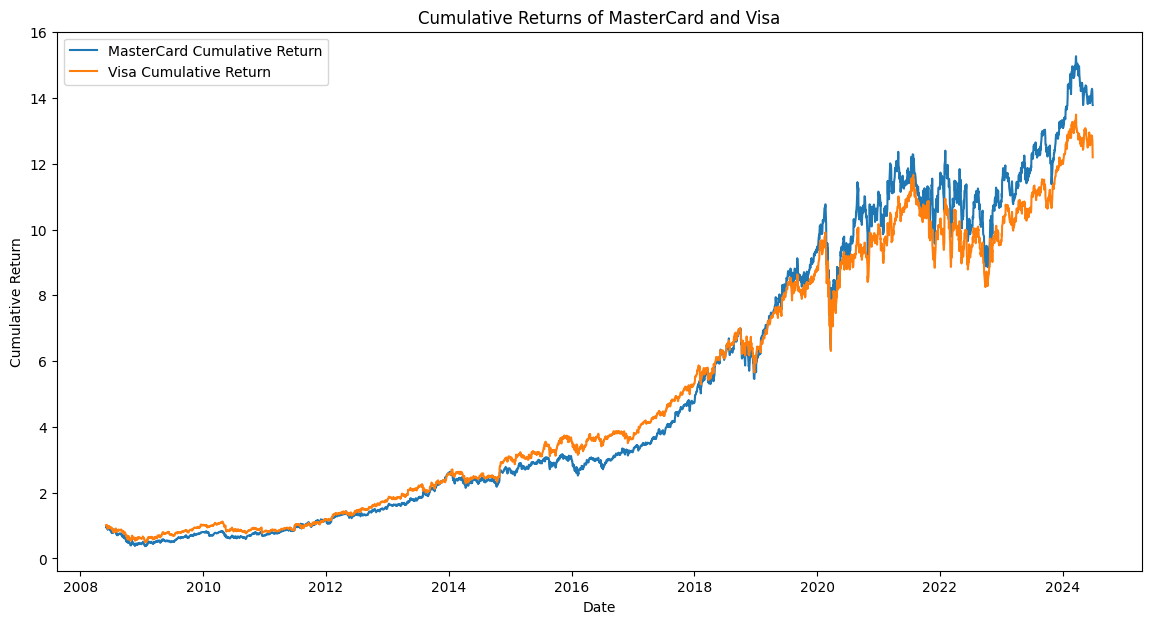

In [ ]:
# Calculate daily returns
data['Return_M'] = data['Close_M'].pct_change()
data['Return_V'] = data['Close_V'].pct_change()

# Calculate cumulative returns
data['Cumulative_Return_M'] = (1 + data['Return_M']).cumprod()
data['Cumulative_Return_V'] = (1 + data['Return_V']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Cumulative_Return_M'], label='MasterCard Cumulative Return')
plt.plot(data.index, data['Cumulative_Return_V'], label='Visa Cumulative Return')
plt.title('Cumulative Returns of MasterCard and Visa')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

**Correlation Analysis**

In [ ]:
correlation = data[['Close_M', 'Close_V']].corr()
print(correlation)

          Close_M   Close_V
Close_M  1.000000  0.996427
Close_V  0.996427  1.000000


**Seasonal Decomposition**

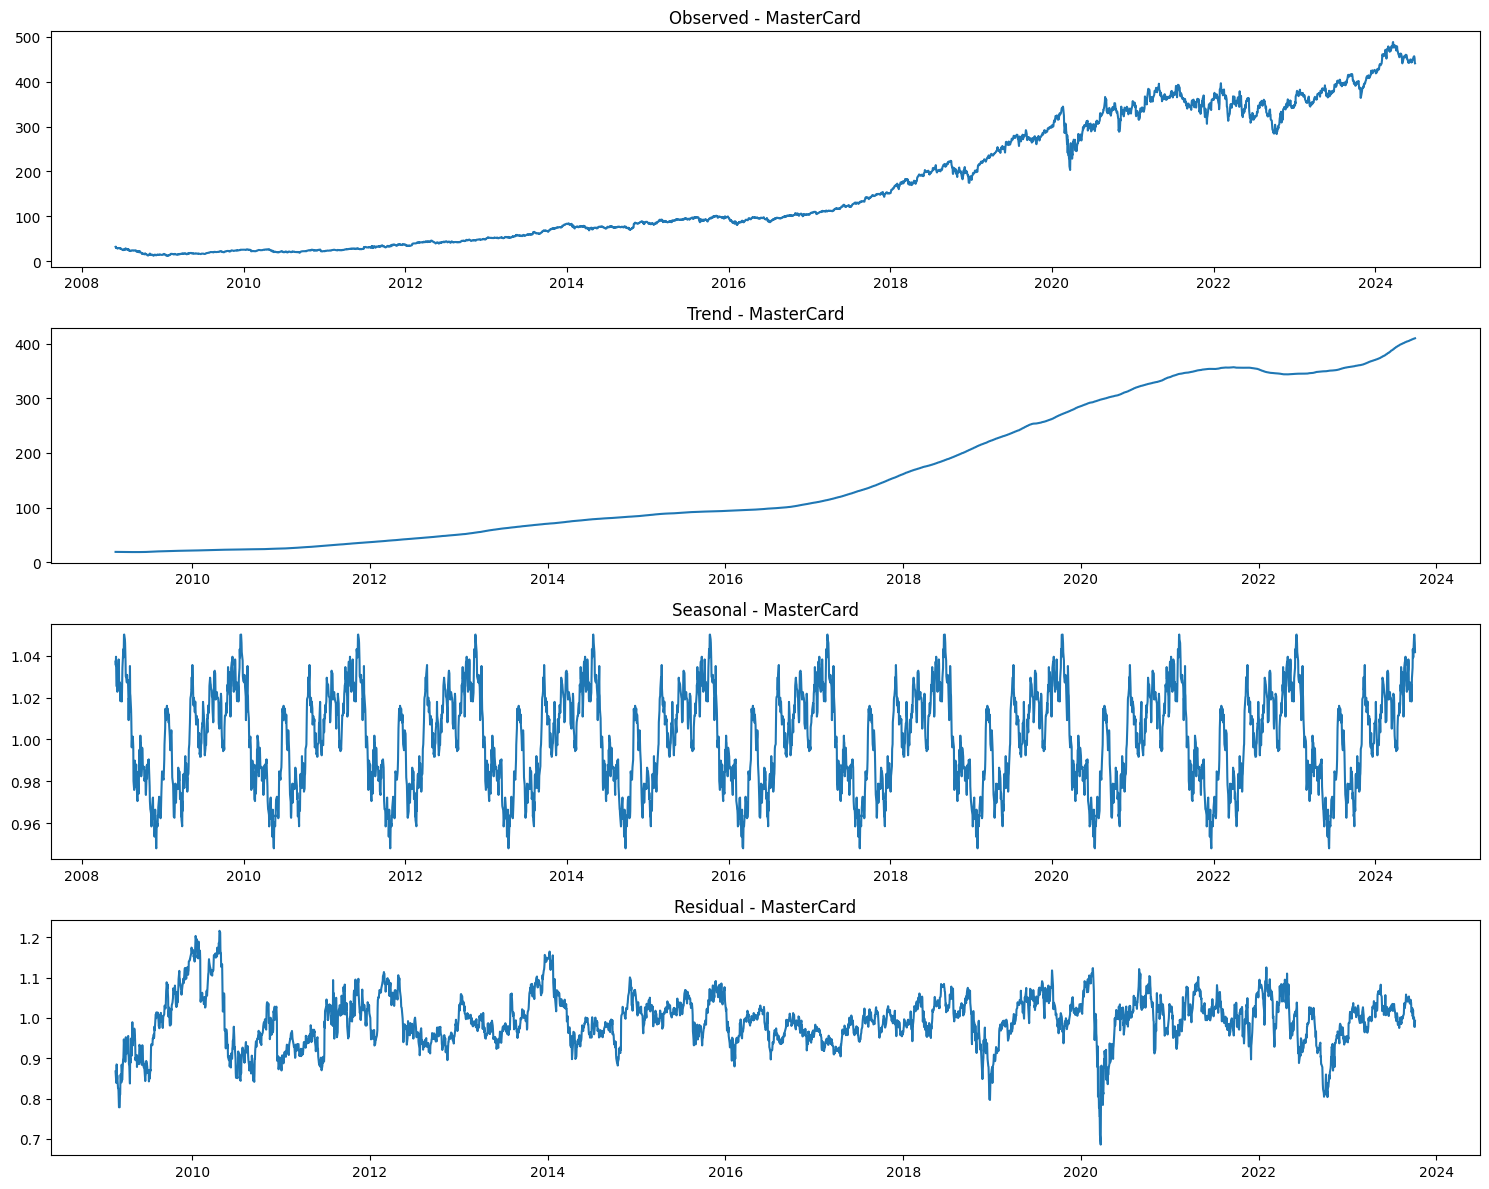

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series for MasterCard
decomposition_M = seasonal_decompose(data['Close_M'], model='multiplicative', period=365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

ax1.plot(decomposition_M.observed)
ax1.set_title('Observed - MasterCard')
ax2.plot(decomposition_M.trend)
ax2.set_title('Trend - MasterCard')
ax3.plot(decomposition_M.seasonal)
ax3.set_title('Seasonal - MasterCard')
ax4.plot(decomposition_M.resid)
ax4.set_title('Residual - MasterCard')

plt.tight_layout()
plt.show()

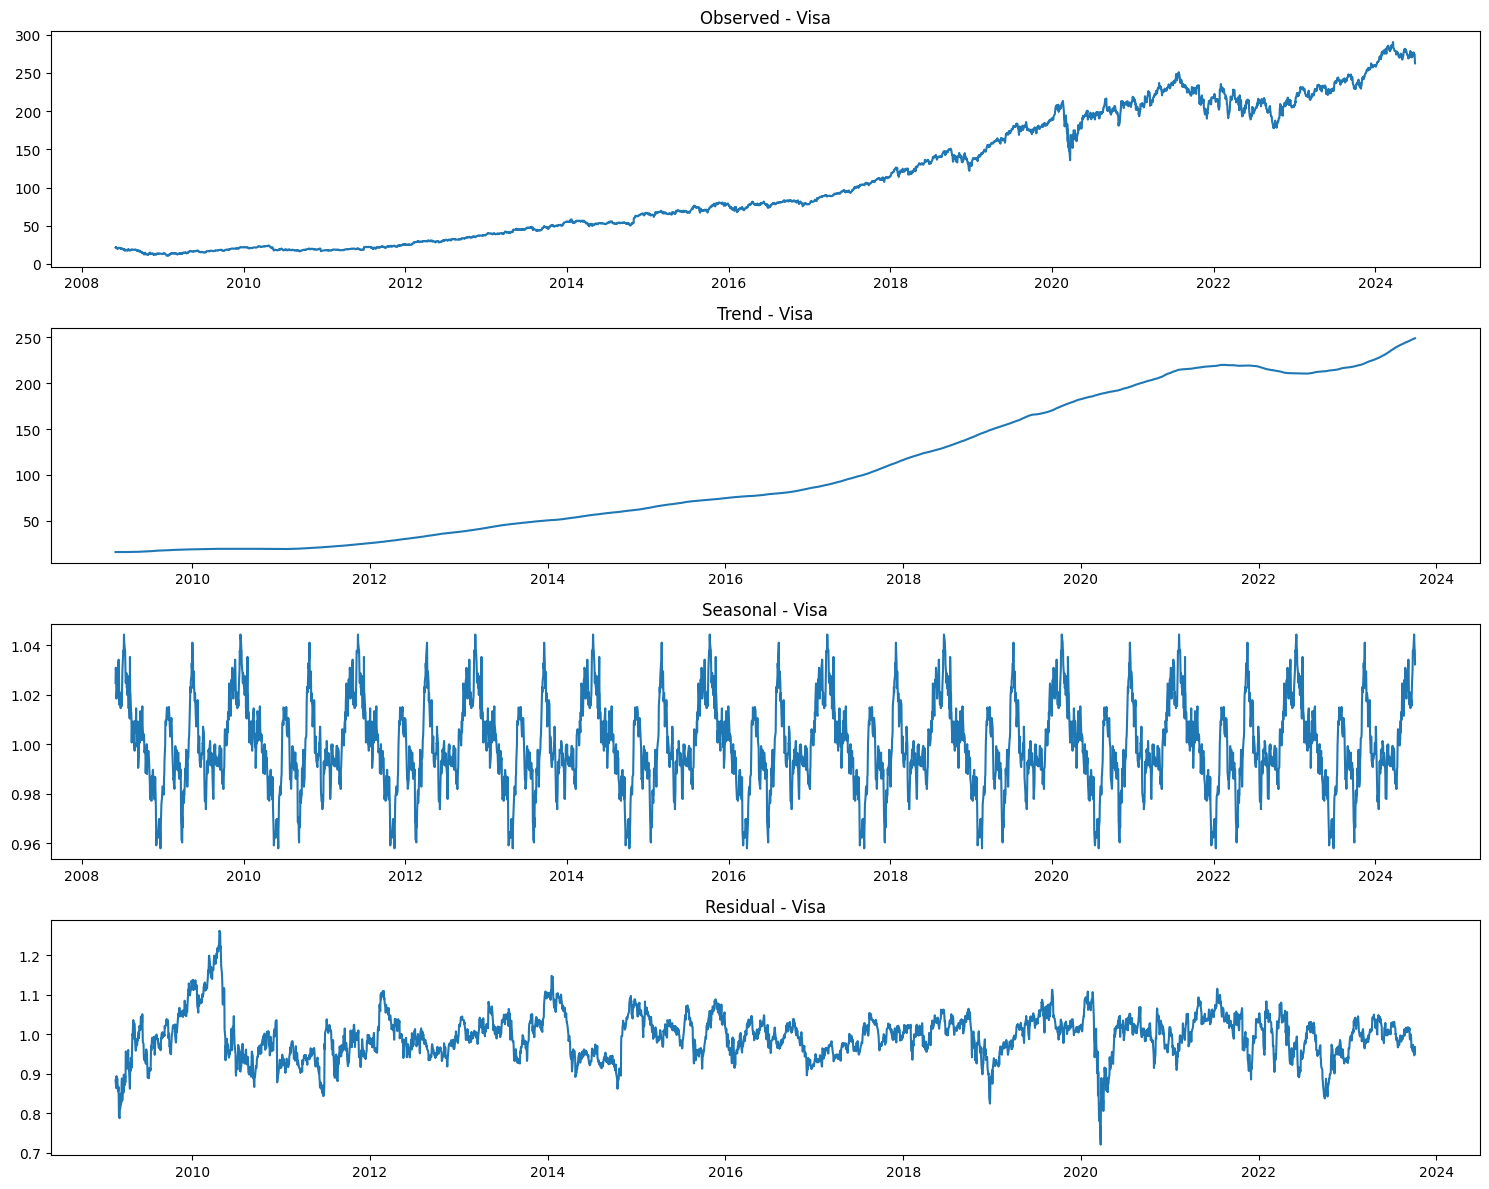

In [ ]:
# Decompose the time series for Visa
decomposition_V = seasonal_decompose(data['Close_V'], model='multiplicative', period=365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

ax1.plot(decomposition_V.observed)
ax1.set_title('Observed - Visa')
ax2.plot(decomposition_V.trend)
ax2.set_title('Trend - Visa')
ax3.plot(decomposition_V.seasonal)
ax3.set_title('Seasonal - Visa')
ax4.plot(decomposition_V.resid)
ax4.set_title('Residual - Visa')

plt.tight_layout()
plt.show()

**checking for stationarity using

---

**Augmented Dickey -Fuller test**
it states that if the p-value is <0.5 the series is stational

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity using the Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

print("ADF Test for MasterCard Close Price:")
adf_test(data['Close_M'])

print("\nADF Test for Visa Close Price:")
adf_test(data['Close_V'])

ADF Test for MasterCard Close Price:
ADF Statistic: 0.7244490658582785
p-value: 0.9903133735035379
Critial Values:
   1%, -3.4319777314769095
Critial Values:
   5%, -2.862259242714302
Critial Values:
   10%, -2.567152860387119

ADF Test for Visa Close Price:
ADF Statistic: 0.5983093602030786
p-value: 0.9875738835892819
Critial Values:
   1%, -3.431978136745109
Critial Values:
   5%, -2.8622594217404305
Critial Values:
   10%, -2.567152955692979


**LSTM model**

In [ ]:
# Step 1: Compute Missing Features
data['Returns_M'] = data['Close_M'].pct_change()
data['Volatility_M'] = data['Returns_M'].rolling(window=20).std().fillna(method='bfill')
data['Returns_V'] = data['Close_V'].pct_change()
data['Volatility_V'] = data['Returns_V'].rolling(window=20).std().fillna(method='bfill')

data['MA_Close_M'] = data['Close_M'].rolling(window=20).mean().fillna(method='bfill')
data['MA_Close_V'] = data['Close_V'].rolling(window=20).mean().fillna(method='bfill')

data['SMA50_M'] = data['Close_M'].rolling(window=50).mean().fillna(method='bfill')
data['SMA50_V'] = data['Close_V'].rolling(window=50).mean().fillna(method='bfill')

data['SMA200_M'] = data['Close_M'].rolling(window=200).mean().fillna(method='bfill')
data['SMA200_V'] = data['Close_V'].rolling(window=200).mean().fillna(method='bfill')


<ipython-input-15-8956eaaab087>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Volatility_M'] = data['Returns_M'].rolling(window=20).std().fillna(method='bfill')
<ipython-input-15-8956eaaab087>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Volatility_V'] = data['Returns_V'].rolling(window=20).std().fillna(method='bfill')
<ipython-input-15-8956eaaab087>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['MA_Close_M'] = data['Close_M'].rolling(window=20).mean().fillna(method='bfill')
<ipython-input-15-8956eaaab087>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['MA_Close_V'] = data['Close_V'].rolling(window=20).

In [ ]:


# Step 2: Feature Selection
features_m = data[['Close_M', 'Volume_M', 'Volatility_M', 'MA_Close_M', 'SMA50_M', 'SMA200_M', 'Returns_M']].dropna()
features_v = data[['Close_V', 'Volume_V', 'Volatility_V', 'MA_Close_V', 'SMA50_V', 'SMA200_V', 'Returns_V']].dropna()

In [ ]:


# Smooth volatility
features_m['Volatility_M'] = features_m['Volatility_M'].rolling(window=5).mean().fillna(method='bfill')
features_v['Volatility_V'] = features_v['Volatility_V'].rolling(window=5).mean().fillna(method='bfill')

<ipython-input-17-5502e6f3ae9e>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_m['Volatility_M'] = features_m['Volatility_M'].rolling(window=5).mean().fillna(method='bfill')
<ipython-input-17-5502e6f3ae9e>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_v['Volatility_V'] = features_v['Volatility_V'].rolling(window=5).mean().fillna(method='bfill')


In [ ]:

# Step 3: Detrend the Data
def detrend_data(prices):
    X = np.arange(len(prices)).reshape(-1, 1)
    y = prices.values
    trend_model = LinearRegression().fit(X, y)
    trend = trend_model.predict(X)
    detrended = y - trend
    return detrended, trend_model

train_size_m = int(len(features_m) * 0.8)
train_size_v = int(len(features_v) * 0.8)

train_prices_m, valid_prices_m = features_m['Close_M'][:train_size_m], features_m['Close_M'][train_size_m:]
train_prices_v, valid_prices_v = features_v['Close_V'][:train_size_v], features_v['Close_V'][train_size_v:]

detrended_m, trend_model_m = detrend_data(features_m['Close_M'])
detrended_v, trend_model_v = detrend_data(features_v['Close_V'])

In [ ]:

# Step 4: Prepare Features and Target
train_features_m, valid_features_m = features_m[:train_size_m], features_m[train_size_m:]
train_features_v, valid_features_v = features_v[:train_size_v], features_v[train_size_v:]

train_detrended_m, valid_detrended_m = detrended_m[:train_size_m], detrended_m[train_size_m:]
train_detrended_v, valid_detrended_v = detrended_v[:train_size_v], detrended_v[train_size_v:]

In [ ]:

# Scale the features
scaler_m = MinMaxScaler()
scaler_v = MinMaxScaler()

scaled_train_features_m = scaler_m.fit_transform(train_features_m)
scaled_valid_features_m = scaler_m.transform(valid_features_m)

scaled_train_features_v = scaler_v.fit_transform(train_features_v)
scaled_valid_features_v = scaler_v.transform(valid_features_v)

scaler_detrended_m = MinMaxScaler()
scaler_detrended_v = MinMaxScaler()

scaled_train_detrended_m = scaler_detrended_m.fit_transform(train_detrended_m.reshape(-1, 1))
scaled_valid_detrended_m = scaler_detrended_m.transform(valid_detrended_m.reshape(-1, 1))

scaled_train_detrended_v = scaler_detrended_v.fit_transform(train_detrended_v.reshape(-1, 1))
scaled_valid_detrended_v = scaler_detrended_v.transform(valid_detrended_v.reshape(-1, 1))

In [ ]:

# Step 5: Create Sequences for LSTM
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60

X_train_m, y_train_m = create_sequences(scaled_train_features_m, scaled_train_detrended_m, seq_length)
X_valid_m, y_valid_m = create_sequences(scaled_valid_features_m, scaled_valid_detrended_m, seq_length)

X_train_v, y_train_v = create_sequences(scaled_train_features_v, scaled_train_detrended_v, seq_length)
X_valid_v, y_valid_v = create_sequences(scaled_valid_features_v, scaled_valid_detrended_v, seq_length)

In [ ]:
# Step 6: Build and Train the LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        LSTM(32, kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse')
    return model

model_m = build_lstm_model((seq_length, X_train_m.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_m = model_m.fit(
    X_train_m, y_train_m,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid_m, y_valid_m),
    callbacks=[early_stopping],
    verbose=1
)

model_v = build_lstm_model((seq_length, X_train_v.shape[2]))
history_v = model_v.fit(
    X_train_v, y_train_v,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid_v, y_valid_v),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 1.2034 - val_loss: 0.8305
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.7506 - val_loss: 0.5676
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.4892 - val_loss: 0.3918
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.3229 - val_loss: 0.2819
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.2172 - val_loss: 0.2071
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.1484 - val_loss: 0.1604
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.1039 - val_loss: 0.1156
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0751 - val_loss: 0.0913
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0562 - val_loss: 0.0941
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0440 - val_loss: 0.0658
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0342 - val_loss: 0.0686
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 

In [ ]:



# Step 7: Make Predictions and Add the Trend Back
predicted_detrended_m = model_m.predict(X_valid_m)
predicted_detrended_m = scaler_detrended_m.inverse_transform(predicted_detrended_m)

future_X_m = np.arange(len(features_m) - len(predicted_detrended_m), len(features_m)).reshape(-1, 1)
trend_m = trend_model_m.predict(future_X_m)
predicted_prices_m = predicted_detrended_m.flatten() + trend_m

actual_prices_m = features_m['Close_M'].iloc[train_size_m + seq_length:].values

predicted_detrended_v = model_v.predict(X_valid_v)
predicted_detrended_v = scaler_detrended_v.inverse_transform(predicted_detrended_v)

future_X_v = np.arange(len(features_v) - len(predicted_detrended_v), len(features_v)).reshape(-1, 1)
trend_v = trend_model_v.predict(future_X_v)
predicted_prices_v = predicted_detrended_v.flatten() + trend_v

actual_prices_v = features_v['Close_V'].iloc[train_size_v + seq_length:].values


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [ ]:
# Step 8: Evaluate the Model
rmse_m = np.sqrt(mean_squared_error(actual_prices_m, predicted_prices_m))
mae_m = mean_absolute_error(actual_prices_m, predicted_prices_m)
print("Mastercard - RMSE:", rmse_m, "MAE:", mae_m)

rmse_v = np.sqrt(mean_squared_error(actual_prices_v, predicted_prices_v))
mae_v = mean_absolute_error(actual_prices_v, predicted_prices_v)
print("Visa - RMSE:", rmse_v, "MAE:", mae_v)

Mastercard - RMSE: 25.522310270740647 MAE: 19.66555644512523
Visa - RMSE: 17.979607674019856 MAE: 14.886659654329105


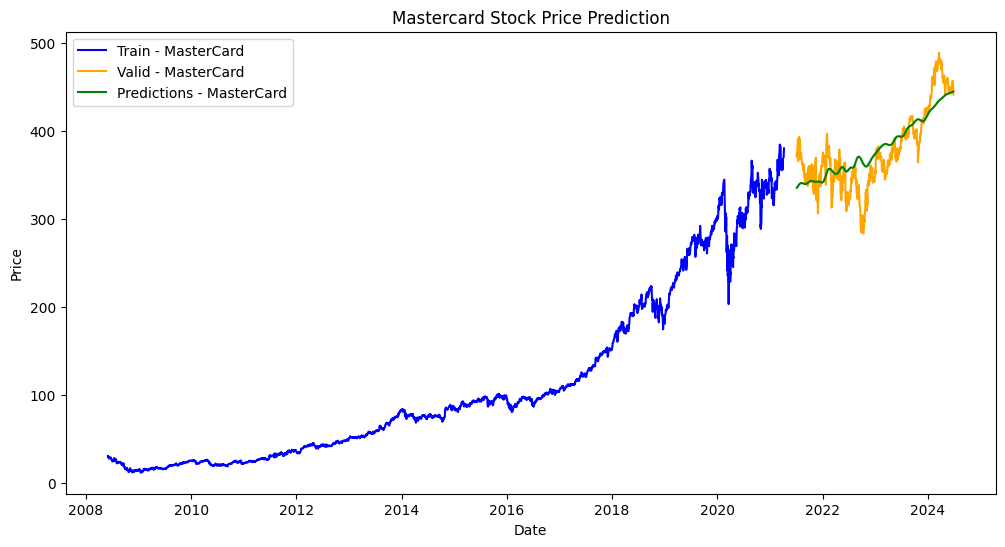

In [ ]:

# Step 9: Visualizing for mastercard
plt.figure(figsize=(12, 6))
plt.plot(data.index[:train_size_m], features_m['Close_M'][:train_size_m], label='Train - MasterCard', color='blue')
plt.plot(data.index[train_size_m + seq_length:train_size_m + seq_length + len(actual_prices_m)], actual_prices_m, label='Valid - MasterCard', color='orange')
plt.plot(data.index[train_size_m + seq_length:train_size_m + seq_length + len(predicted_prices_m)], predicted_prices_m, label='Predictions - MasterCard', color='green')
plt.title('Mastercard Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**Evaluatin the performance** of the model using root mean squared error ,mean absolute percentage error and mean absolute error

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate_model(actual, predicted, label=''):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)

    print(f"\n{label} Performance Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  MAPE: {mape:.2%}")

    # Display last 10 actual vs predicted values
    comparison_data = pd.DataFrame({
        'Actual': actual[-10:],
        'Predicted': predicted[-10:]
    })
    print("\nLast 10 Predictions vs Actuals:")
    print(comparison_data.to_string(index=False))
    print("-" * 50)

    return rmse, mae, mape

# Call the function for both models
evaluate_model(actual_prices_m, predicted_prices_m, label='Mastercard')
evaluate_model(actual_prices_v, predicted_prices_v, label='Visa')



Mastercard Performance Metrics:
  RMSE: 25.5223
  MAE : 19.6656
  MAPE: 5.43%

Last 10 Predictions vs Actuals:
    Actual  Predicted
444.630005 443.610444
448.109985 443.713498
450.109985 443.819623
452.510010 443.924443
454.850006 444.032399
456.959991 444.146664
455.649994 444.264622
452.380005 444.387299
442.750000 444.508503
441.160004 444.634510
--------------------------------------------------

Visa Performance Metrics:
  RMSE: 17.9796
  MAE : 14.8867
  MAPE: 6.78%

Last 10 Predictions vs Actuals:
    Actual  Predicted
270.660004 267.567671
271.170013 267.638568
273.619995 267.708311
276.820007 267.776609
275.220001 267.843817
276.299988 267.910501
273.529999 267.976854
273.600006 268.042989
266.589996 268.108673
262.470001 268.173875
--------------------------------------------------


(np.float64(17.979607674019856), 14.886659654329105, 0.0677971512382482)

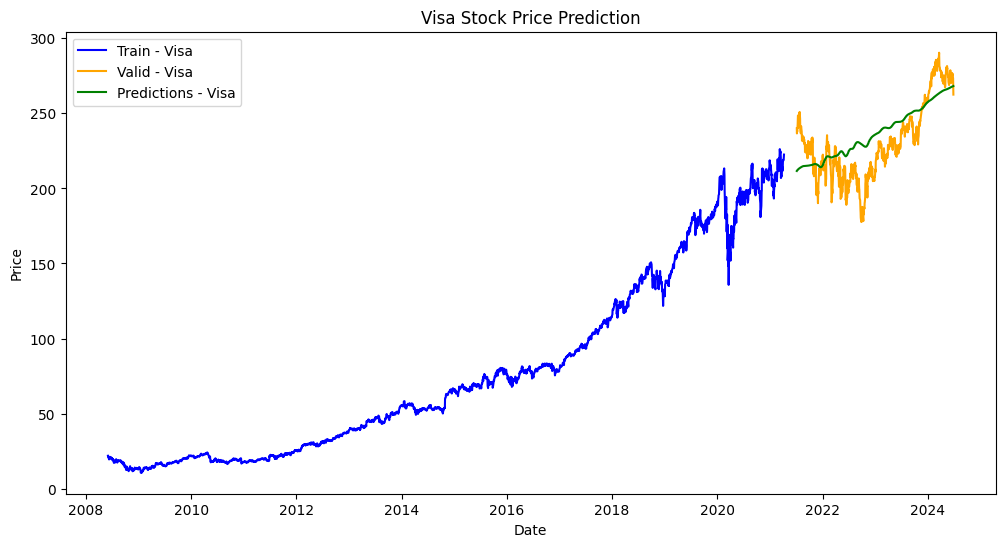

In [ ]:
# Step 10: Visualizing for visa
plt.figure(figsize=(12, 6))
plt.plot(data.index[:train_size_v], features_v['Close_V'][:train_size_v], label='Train - Visa', color='blue')
plt.plot(data.index[train_size_v + seq_length:train_size_v + seq_length + len(actual_prices_v)], actual_prices_v, label='Valid - Visa', color='orange')
plt.plot(data.index[train_size_v + seq_length:train_size_v + seq_length + len(predicted_prices_v)], predicted_prices_v, label='Predictions - Visa', color='green')
plt.title('Visa Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**Correlation Analysis of the variables**

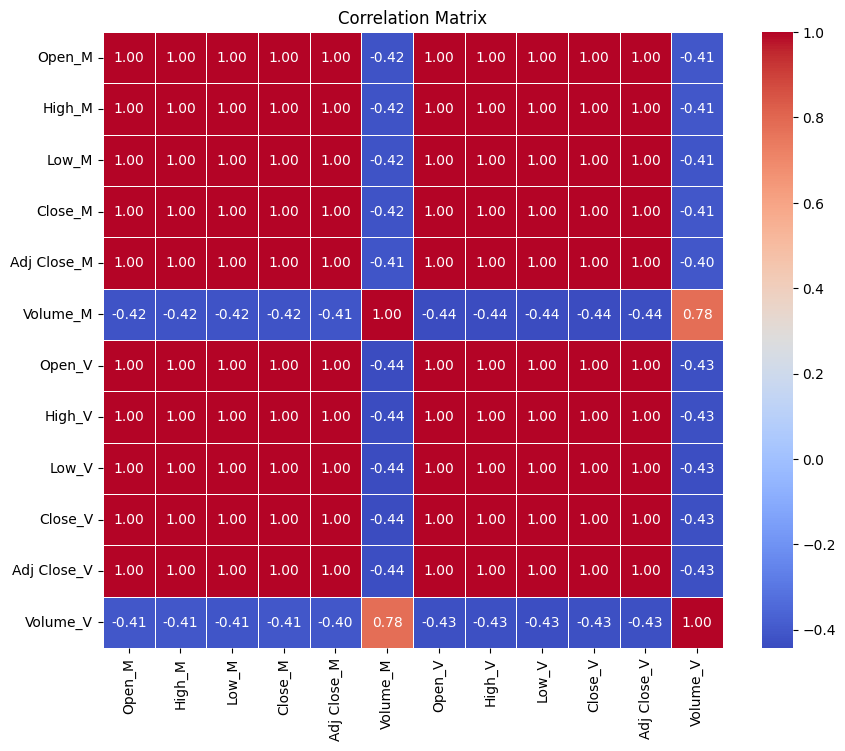

In [10]:
# Select only numeric columns for correlation
import seaborn as sns
numeric_cols = ['Open_M', 'High_M', 'Low_M', 'Close_M', 'Adj Close_M', 'Volume_M',
                'Open_V', 'High_V', 'Low_V', 'Close_V', 'Adj Close_V', 'Volume_V']
 # Create correlation matrix
correlation_matrix = data[numeric_cols].corr()
 # Visualize the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

**Saving the models to deploy them in streamlit**

In [ ]:
import joblib
# Save the LSTM models in .h5 format
model_m.save("lstm_model_mastercard.h5")
model_v.save("lstm_model_visa.h5")


# Save the scalers
joblib.dump(scaler_m, "scaler_mastercard.pkl")
joblib.dump(scaler_v, "scaler_visa.pkl")
joblib.dump(scaler_detrended_m, "scaler_detrended_mastercard.pkl")
joblib.dump(scaler_detrended_v, "scaler_detrended_visa.pkl")

# Save the trend models (Linear Regression)
joblib.dump(trend_model_m, "trend_model_mastercard.pkl")
joblib.dump(trend_model_v, "trend_model_visa.pkl")


['trend_model_visa.pkl']